In [30]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [31]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [32]:
key = os.environ.get('AZURE_SEARCH_KEY', '73f93fc69cf9437b919a1b93c8b94143')

In [33]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [34]:
results = search_images_bing(key, 'Beija-flor')
ims = results.attrgot('contentUrl')
len(ims)

150

In [35]:
tipo_passaro = 'Beija-flor-tesoura','Beija-flor-brilho-de-fogo','Topázio-de-fogo','Besourão-de-bico-grande','Beija-flor-rajado'
path = Path('passaro_beija_flor')

In [36]:
if not path.exists():
    path.mkdir()
    for o in tipo_passaro:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'Beija-flor{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [37]:
fns = get_image_files(path)
fns

(#719) [Path('passaro_beija_flor/Besourão-de-bico-grande/00000055.jpg'),Path('passaro_beija_flor/Besourão-de-bico-grande/00000126.JPG'),Path('passaro_beija_flor/Besourão-de-bico-grande/00000107.jpg'),Path('passaro_beija_flor/Besourão-de-bico-grande/00000036.jpg'),Path('passaro_beija_flor/Besourão-de-bico-grande/00000030.jpg'),Path('passaro_beija_flor/Besourão-de-bico-grande/00000148.jpg'),Path('passaro_beija_flor/Besourão-de-bico-grande/00000110.jpg'),Path('passaro_beija_flor/Besourão-de-bico-grande/00000029.jpg'),Path('passaro_beija_flor/Besourão-de-bico-grande/00000112.jpg'),Path('passaro_beija_flor/Besourão-de-bico-grande/00000091.jpg')...]

In [38]:
failed = verify_images(fns)
failed

(#1) [Path('passaro_beija_flor/Topázio-de-fogo/00000110.png')]

In [39]:
failed.map(Path.unlink);

In [40]:
passaros = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [41]:
dls = passaros.dataloaders(path)

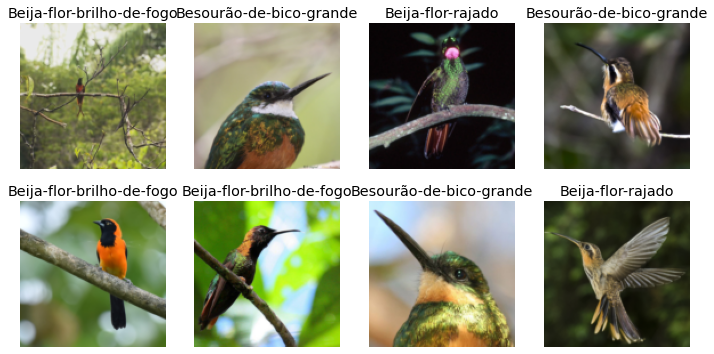

In [42]:
dls.valid.show_batch(max_n=8, nrows=2)

In [43]:
passaros = passaros.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = passaros.dataloaders(path)

In [44]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.556407,1.692288,0.594406,00:09


epoch,train_loss,valid_loss,error_rate,time
0,1.788672,1.312286,0.482517,00:10
1,1.560382,1.202489,0.433566,00:10
2,1.438215,1.189932,0.398601,00:10
3,1.317537,1.181896,0.412587,00:10


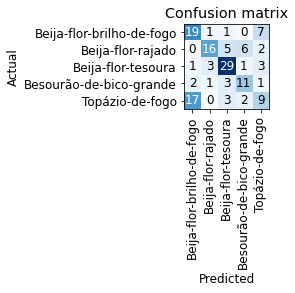

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

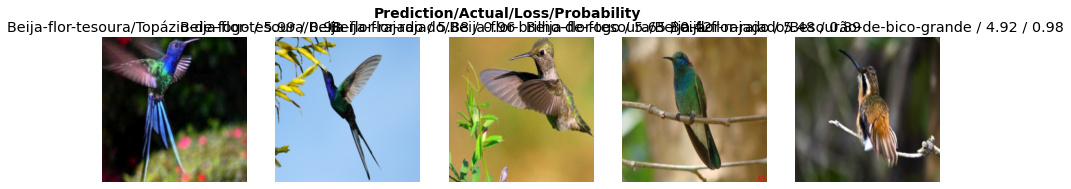

In [46]:
interp.plot_top_losses(5, nrows=1)

In [47]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [48]:
learn.export('beija_flor.pkl')

In [49]:
path = Path()
path.ls(file_exts='.pkl')

(#2) [Path('beija_flor.pkl'),Path('export.pkl')]

In [50]:
learn_inf = load_learner(path/'beija_flor.pkl')

In [51]:
learn_inf.predict('passaro_beija_flor/Besourão-de-bico-grande/00000000.jpg')

('Besourão-de-bico-grande',
 TensorBase(3),
 TensorBase([0.1343, 0.1018, 0.1835, 0.5537, 0.0267]))

In [52]:
learn_inf.dls.vocab

['Beija-flor-brilho-de-fogo', 'Beija-flor-rajado', 'Beija-flor-tesoura', 'Besourão-de-bico-grande', 'Topázio-de-fogo']

In [54]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [55]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['passaro_beija_flor/Besourão-de-bico-grande/00000000.jpg'])

In [56]:
img = PILImage.create(btn_upload.data[-1])

In [57]:
pred,pred_idx,probs = learn_inf.predict(img)

In [59]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [60]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Predição: {pred}; Probabilidade: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Predição: Besourão-de-bico-grande; Probabilidade: 0.5537')

In [61]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [62]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Predição: {pred}; Probabilidade: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [63]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [67]:
#hide_output
VBox([widgets.Label('Escolha seu passaro!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [66]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.7 MB 8.8 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 35.4 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 15.9 MB/s eta 0:00:01
     |████████████████████████████████| 558 kB 42.5 MB/s eta 0:00:01
     |████████████████████████████████| 397 kB 33.8 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 14.3 MB/s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbdev 1.1.23 requires nbconvert<6, but you have nbconvert 6.4.2 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.3.1 OK
